<img src="https://github.com/pmservice/ai-openscale-tutorials/raw/master/notebooks/images/banner.png" align="left" alt="banner">

# Working with Watson Machine Learning

This notebook should be run using with **Python 3.x with Spark** runtime environment. **If you are viewing this in Watson Studio and do not see Python 3.x with Spark in the upper right corner of your screen, please update the runtime now.** It requires service credentials for the following services:
  * Watson OpenScale
  * Watson Machine Learning
  * DB2
  
The notebook will train, create and deploy a German Credit Risk model, configure OpenScale to monitor that deployment, and inject seven days' worth of historical records and measurements for viewing in the OpenScale Insights dashboard.

### Contents

- [Setup](#setup)
- [Model building and deployment](#model)
- [OpenScale configuration](#openscale)
- [Quality monitor and feedback logging](#quality)
- [Fairness monitoring and explanations](#fairness)
- [Custom monitors and metrics](#custom)
- [Payload analytics](#analytics)
- [Historical data](#historical)

# Setup <a name="setup"></a>

## Package installation

In [1]:
import warnings
warnings.filterwarnings('ignore')

Waiting for a Spark session to start...
Spark Initialization Done! ApplicationId = app-20191104152319-0003
KERNEL_ID = 38ef23d6-4002-468a-806f-512bcc44fad7


In [3]:
!rm -rf /home/spark/shared/user-libs/python3.6*

!pip install --upgrade ibm-ai-openscale --no-cache | tail -n 1
!pip install --upgrade watson-machine-learning-client-V4 | tail -n 1
!pip install --upgrade numpy --no-cache | tail -n 1
!pip install --upgrade SciPy --no-cache | tail -n 1
!pip install lime --no-cache | tail -n 1
!pip install pixiedust | tail -n 1

tensorflow 1.13.1 requires tensorboard<1.14.0,>=1.13.0, which is not installed.
ibm-cos-sdk-core 2.4.3 has requirement urllib3<1.25,>=1.20, but you'll have urllib3 1.25.6 which is incompatible.
botocore 1.12.82 has requirement urllib3<1.25,>=1.20, but you'll have urllib3 1.25.6 which is incompatible.
tensorflow 1.13.1 requires tensorboard<1.14.0,>=1.13.0, which is not installed.
botocore 1.12.82 has requirement urllib3<1.25,>=1.20, but you'll have urllib3 1.25.6 which is incompatible.
tensorflow 1.13.1 requires tensorboard<1.14.0,>=1.13.0, which is not installed.
tensorflow 1.13.1 requires tensorboard<1.14.0,>=1.13.0, which is not installed.
tensorflow 1.13.1 requires tensorboard<1.14.0,>=1.13.0, which is not installed.
botocore 1.12.82 has requirement urllib3<1.25,>=1.20, but you'll have urllib3 1.25.6 which is incompatible.
Target directory /home/spark/shared/user-libs/python3.6/six-1.12.0.dist-info already exists. Specify --upgrade to force replacement.
Target directory /home/spark/

### Action: restart the kernel!

## Configure credentials

- WOS_CREDENTIALS (ICP)
- WML_CREDENTIALS (ICP)
- DATABASE_CREDENTIALS (DB2 on ICP)
- SCHEMA_NAME

In [1]:
WOS_CREDENTIALS = {
    "url": "***",
    "username": "***",
    "password": "***"
}

Waiting for a Spark session to start...
Spark Initialization Done! ApplicationId = app-20191104144328-0000
KERNEL_ID = 38ef23d6-4002-468a-806f-512bcc44fad7


In [118]:
# The code was removed by Watson Studio for sharing.

In [3]:
WML_CREDENTIALS = WOS_CREDENTIALS.copy()
WML_CREDENTIALS['instance_id']='openshift'
WML_CREDENTIALS['version']='2.5.0'

In [10]:
DATABASE_CREDENTIALS = {
    "jdbcurl": "***",
    "hostname": "***",
    "username": "***",
    "password": "***",
    "port": 50000,
    "db": "***",
    "dsn": "***",
    "uri": "***"
}

In [163]:
# The code was removed by Watson Studio for sharing.

### Action: put created schema name below.

In [11]:
SCHEMA_NAME = 'AIOSFASTPATHICP'

## Run the notebook

At this point, the notebook is ready to run. You can either run the cells one at a time, or click the **Kernel** option above and select **Restart and Run All** to run all the cells.

# Model building and deployment <a name="model"></a>

In this section you will learn how to train Spark MLLib model and next deploy it as web-service using Watson Machine Learning service.

## Load the training data from github

In [3]:
!rm german_credit_data_biased_training.csv
!wget https://raw.githubusercontent.com/pmservice/ai-openscale-tutorials/master/assets/historical_data/german_credit_risk/wml/german_credit_data_biased_training.csv

rm: cannot remove 'german_credit_data_biased_training.csv': No such file or directory
--2019-11-04 14:43:47--  https://raw.githubusercontent.com/pmservice/ai-openscale-tutorials/master/assets/historical_data/german_credit_risk/wml/german_credit_data_biased_training.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 199.232.8.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|199.232.8.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 689622 (673K) [text/plain]
Saving to: 'german_credit_data_biased_training.csv'

100%[======================================>] 689,622     --.-K/s   in 0.06s   

2019-11-04 14:43:48 (11.7 MB/s) - 'german_credit_data_biased_training.csv' saved [689622/689622]



In [7]:
from pyspark.sql import SparkSession
import pandas as pd
import json

spark = SparkSession.builder.getOrCreate()
pd_data = pd.read_csv("german_credit_data_biased_training.csv", sep=",", header=0)
df_data = spark.read.csv(path="german_credit_data_biased_training.csv", sep=",", header=True, inferSchema=True)
df_data.head()

Row(CheckingStatus='0_to_200', LoanDuration=31, CreditHistory='credits_paid_to_date', LoanPurpose='other', LoanAmount=1889, ExistingSavings='100_to_500', EmploymentDuration='less_1', InstallmentPercent=3, Sex='female', OthersOnLoan='none', CurrentResidenceDuration=3, OwnsProperty='savings_insurance', Age=32, InstallmentPlans='none', Housing='own', ExistingCreditsCount=1, Job='skilled', Dependents=1, Telephone='none', ForeignWorker='yes', Risk='No Risk')

## Explore data

In [8]:
df_data.printSchema()

root
 |-- CheckingStatus: string (nullable = true)
 |-- LoanDuration: integer (nullable = true)
 |-- CreditHistory: string (nullable = true)
 |-- LoanPurpose: string (nullable = true)
 |-- LoanAmount: integer (nullable = true)
 |-- ExistingSavings: string (nullable = true)
 |-- EmploymentDuration: string (nullable = true)
 |-- InstallmentPercent: integer (nullable = true)
 |-- Sex: string (nullable = true)
 |-- OthersOnLoan: string (nullable = true)
 |-- CurrentResidenceDuration: integer (nullable = true)
 |-- OwnsProperty: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- InstallmentPlans: string (nullable = true)
 |-- Housing: string (nullable = true)
 |-- ExistingCreditsCount: integer (nullable = true)
 |-- Job: string (nullable = true)
 |-- Dependents: integer (nullable = true)
 |-- Telephone: string (nullable = true)
 |-- ForeignWorker: string (nullable = true)
 |-- Risk: string (nullable = true)



In [9]:
print("Number of records: " + str(df_data.count()))

Number of records: 5000


## Visualize data with pixiedust

In [10]:
import pixiedust

Pixiedust database opened successfully


In [ ]:
display(df_data)

## Create a model

In [12]:
spark_df = df_data
(train_data, test_data) = spark_df.randomSplit([0.8, 0.2], 24)

MODEL_NAME = "Spark German Risk Model - Final"
DEPLOYMENT_NAME = "Spark German Risk Deployment - Final"

print("Number of records for training: " + str(train_data.count()))
print("Number of records for evaluation: " + str(test_data.count()))

spark_df.printSchema()

Number of records for training: 4016
Number of records for evaluation: 984
root
 |-- CheckingStatus: string (nullable = true)
 |-- LoanDuration: integer (nullable = true)
 |-- CreditHistory: string (nullable = true)
 |-- LoanPurpose: string (nullable = true)
 |-- LoanAmount: integer (nullable = true)
 |-- ExistingSavings: string (nullable = true)
 |-- EmploymentDuration: string (nullable = true)
 |-- InstallmentPercent: integer (nullable = true)
 |-- Sex: string (nullable = true)
 |-- OthersOnLoan: string (nullable = true)
 |-- CurrentResidenceDuration: integer (nullable = true)
 |-- OwnsProperty: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- InstallmentPlans: string (nullable = true)
 |-- Housing: string (nullable = true)
 |-- ExistingCreditsCount: integer (nullable = true)
 |-- Job: string (nullable = true)
 |-- Dependents: integer (nullable = true)
 |-- Telephone: string (nullable = true)
 |-- ForeignWorker: string (nullable = true)
 |-- Risk: string (nullable = 

The code below creates a Random Forest Classifier with Spark, setting up string indexers for the categorical features and the label column. Finally, this notebook creates a pipeline including the indexers and the model, and does an initial Area Under ROC evaluation of the model.

In [13]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, IndexToString, VectorAssembler
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml import Pipeline, Model

si_CheckingStatus = StringIndexer(inputCol = 'CheckingStatus', outputCol = 'CheckingStatus_IX')
si_CreditHistory = StringIndexer(inputCol = 'CreditHistory', outputCol = 'CreditHistory_IX')
si_LoanPurpose = StringIndexer(inputCol = 'LoanPurpose', outputCol = 'LoanPurpose_IX')
si_ExistingSavings = StringIndexer(inputCol = 'ExistingSavings', outputCol = 'ExistingSavings_IX')
si_EmploymentDuration = StringIndexer(inputCol = 'EmploymentDuration', outputCol = 'EmploymentDuration_IX')
si_Sex = StringIndexer(inputCol = 'Sex', outputCol = 'Sex_IX')
si_OthersOnLoan = StringIndexer(inputCol = 'OthersOnLoan', outputCol = 'OthersOnLoan_IX')
si_OwnsProperty = StringIndexer(inputCol = 'OwnsProperty', outputCol = 'OwnsProperty_IX')
si_InstallmentPlans = StringIndexer(inputCol = 'InstallmentPlans', outputCol = 'InstallmentPlans_IX')
si_Housing = StringIndexer(inputCol = 'Housing', outputCol = 'Housing_IX')
si_Job = StringIndexer(inputCol = 'Job', outputCol = 'Job_IX')
si_Telephone = StringIndexer(inputCol = 'Telephone', outputCol = 'Telephone_IX')
si_ForeignWorker = StringIndexer(inputCol = 'ForeignWorker', outputCol = 'ForeignWorker_IX')

In [14]:
si_Label = StringIndexer(inputCol="Risk", outputCol="label").fit(spark_df)
label_converter = IndexToString(inputCol="prediction", outputCol="predictedLabel", labels=si_Label.labels)

In [15]:
va_features = VectorAssembler(inputCols=["CheckingStatus_IX", "CreditHistory_IX", "LoanPurpose_IX", "ExistingSavings_IX", "EmploymentDuration_IX", "Sex_IX", \
                                         "OthersOnLoan_IX", "OwnsProperty_IX", "InstallmentPlans_IX", "Housing_IX", "Job_IX", "Telephone_IX", "ForeignWorker_IX", \
                                         "LoanDuration", "LoanAmount", "InstallmentPercent", "CurrentResidenceDuration", "LoanDuration", "Age", "ExistingCreditsCount", \
                                         "Dependents"], outputCol="features")

In [16]:
from pyspark.ml.classification import RandomForestClassifier
classifier = RandomForestClassifier(featuresCol="features")

pipeline = Pipeline(stages=[si_CheckingStatus, si_CreditHistory, si_EmploymentDuration, si_ExistingSavings, si_ForeignWorker, si_Housing, si_InstallmentPlans, si_Job, si_LoanPurpose, si_OthersOnLoan,\
                               si_OwnsProperty, si_Sex, si_Telephone, si_Label, va_features, classifier, label_converter])
model = pipeline.fit(train_data)

In [17]:
predictions = model.transform(test_data)
evaluatorDT = BinaryClassificationEvaluator(rawPredictionCol="prediction",  metricName='areaUnderROC')
area_under_curve = evaluatorDT.evaluate(predictions)

evaluatorDT = BinaryClassificationEvaluator(rawPredictionCol="prediction",  metricName='areaUnderPR')
area_under_PR = evaluatorDT.evaluate(predictions)
#default evaluation is areaUnderROC
print("areaUnderROC = %g" % area_under_curve, "areaUnderPR = %g" % area_under_PR)

areaUnderROC = 0.702086 areaUnderPR = 0.610609


In [18]:
# extra code: evaluate more metrics by exporting them into pandas and numpy
from sklearn.metrics import classification_report
y_pred = predictions.toPandas()['prediction']
y_pred = ['Risk' if pred == 1.0 else 'No Risk' for pred in y_pred]
y_test = test_data.toPandas()['Risk']
print(classification_report(y_test, y_pred, target_names=['Risk', 'No Risk']))

              precision    recall  f1-score   support

        Risk       0.79      0.89      0.84       657
     No Risk       0.70      0.51      0.59       327

   micro avg       0.77      0.77      0.77       984
   macro avg       0.74      0.70      0.71       984
weighted avg       0.76      0.77      0.75       984



## Publish the model

In this section, the notebook uses Watson Machine Learning to save the model (including the pipeline) to the WML instance. Previous versions of the model are removed so that the notebook can be run again, resetting all data for another demo.

In [ ]:
from watson_machine_learning_client import WatsonMachineLearningAPIClient
import json

wml_client = WatsonMachineLearningAPIClient(WML_CREDENTIALS)

# this is a new feature in CP4D, in order to deploy a model, you would have to create different
# deployment spaces and deploy your models there. You can list all the spaces using the .list()
# function, or you can create new spaces by going to CP4D menu on top left corner --> analyze -->
# analytics deployments --> New Deployment Space. Once you know which space you want to deploy
# in, simply use the GUID of the space as argument for .set.default_space() function below
wml_client.spaces.list()
# wml_client.set.default_space('323608a7-21d3-48c8-8c62-dcf4bfe06e17')

### Remove existing model and deployment

In [ ]:
deployment_details = wml_client.deployments.get_details()
for deployment in deployment_details['resources']:
    deployment_id = deployment['metadata']['guid']
    model_id = deployment['entity']['asset']['href'].split('/')[3].split('?')[0]
    if deployment['entity']['name'] == DEPLOYMENT_NAME:
        print('Deleting deployment id', deployment_id)
        wml_client.deployments.delete(deployment_id)
        print('Deleting model id', model_id)
        wml_client.repository.delete(model_id)
wml_client.repository.list_models()

In [ ]:
wml_models = wml_client.repository.get_model_details()
model_uid = None

for model_in in wml_models['resources']:
    if MODEL_NAME == model_in['entity']['name']:
        model_uid = model_in['metadata']['guid']
        break

if model_uid is None:
    print("Storing model ...")
    metadata = {
        wml_client.repository.ModelMetaNames.NAME: MODEL_NAME,
        wml_client.repository.ModelMetaNames.TYPE: 'mllib_2.3',
        wml_client.repository.ModelMetaNames.RUNTIME_UID: 'spark-mllib_2.3',
    }

    published_model_details = wml_client.repository.store_model(model, metadata, training_data=df_data,  pipeline=pipeline)
    model_uid = wml_client.repository.get_model_uid(published_model_details)
    print("Done")

In [ ]:
model_uid

## Deploy the model

The next section of the notebook deploys the model as a RESTful web service in Watson Machine Learning. The deployed model will have a scoring URL you can use to send data to the model for predictions.

In [30]:
wml_deployments = wml_client.deployments.get_details()
deployment_uid = None
for deployment in wml_deployments['resources']:
    if DEPLOYMENT_NAME == deployment['entity']['name']:
        deployment_uid = deployment['metadata']['guid']
        break

if deployment_uid is None:
    print("Deploying model...")
    meta_props = {
        wml_client.deployments.ConfigurationMetaNames.NAME: DEPLOYMENT_NAME,
        wml_client.deployments.ConfigurationMetaNames.ONLINE: {}
    }
    deployment = wml_client.deployments.create(artifact_uid=model_uid, meta_props=meta_props)
    deployment_uid = wml_client.deployments.get_uid(deployment)
    
print("Model id: {}".format(model_uid))
print("Deployment id: {}".format(deployment_uid))

Deploying model...


#######################################################################################

Synchronous deployment creation for uid: '4728915f-08bc-493d-8453-3aaf4d981d75' started

#######################################################################################


initializing..
ready


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='c592c5af-8aab-463f-96df-d1904896e1ff'
------------------------------------------------------------------------------------------------


Model id: 4728915f-08bc-493d-8453-3aaf4d981d75
Deployment id: c592c5af-8aab-463f-96df-d1904896e1ff


# Configure OpenScale <a name="openscale"></a>

The notebook will now import the necessary libraries and set up a Python OpenScale client.

In [7]:
from ibm_ai_openscale import APIClient4ICP
from ibm_ai_openscale.engines import *
from ibm_ai_openscale.utils import *
from ibm_ai_openscale.supporting_classes import PayloadRecord, Feature
from ibm_ai_openscale.supporting_classes.enums import *

In [8]:
ai_client = APIClient4ICP(WOS_CREDENTIALS)
ai_client.version

ConnectionError: HTTPSConnectionPool(host='namespace1-cpd-namespace1.apps.zloct36-lb-1.fyre.ibm.com', port=443): Max retries exceeded with url: /v1/preauth/validateAuth (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x7fb4b3c52630>: Failed to establish a new connection: [Errno -2] Name or service not known',))

## Create datamart

### Set up datamart

Watson OpenScale uses a database to store payload logs and calculated metrics. If an OpenScale datamart exists in Db2, the existing datamart will be used and no data will be overwritten.

Prior instances of the German Credit model will be removed from OpenScale monitoring.

In [33]:
try:
    data_mart_details = ai_client.data_mart.get_details()
    print('Using existing external datamart')
except:
    print('Setting up external datamart')
    ai_client.data_mart.setup(db_credentials=DATABASE_CREDENTIALS, schema=SCHEMA_NAME)

Using existing external datamart


In [34]:
data_mart_details = ai_client.data_mart.get_details()

## Bind machine learning engines

Watson OpenScale needs to be bound to the Watson Machine Learning instance to capture payload data into and out of the model. If this binding already exists, this code will output a warning message and use the existing binding.

In [35]:
binding_uid = ai_client.data_mart.bindings.add('WML instance', WatsonMachineLearningInstance4ICP())
if binding_uid is None:
    binding_uid = ai_client.data_mart.bindings.get_details()['service_bindings'][0]['metadata']['guid']
bindings_details = ai_client.data_mart.bindings.get_details()
ai_client.data_mart.bindings.list()

Warning during bind instance.
Status code: 409, body: {"errors":[{"code":"AIQCS0010W","message":"Service Binding with this id is already defined"}],"trace":"N2Q5MTYwMTUtNmU0OS00MTcwLWE1NzQtM2I0Njk2MjZhNjA2"}


openshift,chris_wml,watson_machine_learning,2019-10-31T16:24:18.783Z
999,ICP WML Instance,watson_machine_learning,2019-10-31T04:58:14.439Z


In [36]:
print(binding_uid)

999


In [37]:
print(ai_client.data_mart.bindings.list())

openshift,chris_wml,watson_machine_learning,2019-10-31T16:24:18.783Z
999,ICP WML Instance,watson_machine_learning,2019-10-31T04:58:14.439Z


None


In [38]:
ai_client.data_mart.bindings.list_assets()

4728915f-08bc-493d-8453-3aaf4d981d75,Spark German Risk Model - Final,2019-11-01T19:01:56.002Z,model,mllib_2.3,999,False
ebbeef07-114d-4b3e-ac9b-429e55b51cf4,scikit-trained-model.zip model,2019-11-01T15:50:11.002Z,model,scikit-learn_0.20,openshift,False
2048ac02-1106-4d29-aa0b-aba4f0dc49d4,CreditRiskXGBoostNative,2019-11-01T14:53:24.002Z,model,xgboost_0.82,999,True
8cca15ba-9061-40a7-8704-a4011465f786,VideoGamesXGBoost,2019-11-01T14:25:46.002Z,model,xgboost_0.82,999,True
cd3a9730-4d37-4a8e-a4ce-e69fe90e4070,GoSales_binary,2019-11-01T13:51:27.002Z,model,mllib_2.3,999,True
9aa8bc00-d8d8-4aa9-8492-a2bd4e7f7527,JF GoSales - P1 ExtraTreesClassifierEstimator,2019-10-31T20:27:42.002Z,model,wml-hybrid_0.1,openshift,False
ad01058f-4591-4cdc-9649-c09d38d39ed2,tf,2019-10-31T20:20:29.002Z,model,tensorflow_1.14,openshift,False
393d54be-a344-48c9-89c7-507dc39c6581,RedWineModelXGBoost,2019-10-31T19:10:15.002Z,model,xgboost_0.82,999,True
71912b92-3f02-4ee1-9691-8308d3948e9f,autoai-v1 - P3 LGBMClassifierEstimator,2019-10-31T18:26:29.002Z,model,wml-hybrid_0.1,openshift,False
4dc18be1-bbb3-40f3-afda-84406549b21e,AutoAI Titanic Model,2019-10-31T18:13:38.002Z,model,wml-hybrid_0.1,openshift,False
81b6dfec-1c02-42f3-a8b7-e545cb7b0276,AutoAI Ghosts Model,2019-10-31T18:01:57.002Z,model,wml-hybrid_0.1,openshift,False


## Subscriptions

### Remove existing credit risk subscriptions

This code removes previous subscriptions to the German Credit model to refresh the monitors with the new model and new data.

In [39]:
subscriptions_uids = ai_client.data_mart.subscriptions.get_uids()
for subscription in subscriptions_uids:
    sub_name = ai_client.data_mart.subscriptions.get_details(subscription)['entity']['asset']['name']
    if sub_name == MODEL_NAME:
        ai_client.data_mart.subscriptions.delete(subscription)
        print('Deleted existing subscription for', MODEL_NAME)

This code creates the model subscription in OpenScale using the Python client API. Note that we need to provide the model unique identifier, and some information about the model itself.

In [40]:
subscription = ai_client.data_mart.subscriptions.add(WatsonMachineLearningAsset(
    model_uid,
    problem_type=ProblemType.BINARY_CLASSIFICATION,
    input_data_type=InputDataType.STRUCTURED,
    label_column='Risk',
    prediction_column='predictedLabel',
    probability_column='probability',
    feature_columns = ["CheckingStatus","LoanDuration","CreditHistory","LoanPurpose","LoanAmount","ExistingSavings","EmploymentDuration","InstallmentPercent","Sex","OthersOnLoan","CurrentResidenceDuration","OwnsProperty","Age","InstallmentPlans","Housing","ExistingCreditsCount","Job","Dependents","Telephone","ForeignWorker"],
    categorical_columns = ["CheckingStatus","CreditHistory","LoanPurpose","ExistingSavings","EmploymentDuration","Sex","OthersOnLoan","OwnsProperty","InstallmentPlans","Housing","Job","Telephone","ForeignWorker"]
))

if subscription is None:
    print('Subscription already exists; get the existing one')
    subscriptions_uids = ai_client.data_mart.subscriptions.get_uids()
    for sub in subscriptions_uids:
        if ai_client.data_mart.subscriptions.get_details(sub)['entity']['asset']['name'] == MODEL_NAME:
            subscription = ai_client.data_mart.subscriptions.get(sub)

Get subscription list

In [41]:
subscriptions_uids = ai_client.data_mart.subscriptions.get_uids()
ai_client.data_mart.subscriptions.list()

39ffe632-77dd-4c6c-aee3-74755bc8b551,Spark German Risk Model - Final,model,999,2019-11-01T19:04:48.187Z
4d2a261d-7b89-4b5a-bd28-f96cbe86bc84,CreditRiskXGBoostNative,model,999,2019-11-01T14:54:33.341Z
f4bf075d-8b82-4288-84c1-76b8dc24d143,VideoGamesXGBoost,model,999,2019-11-01T14:30:13.756Z
ed8b2353-cc92-4c6c-beb3-6120f148a09a,GoSales_binary,model,999,2019-11-01T13:54:00.738Z
c5087e85-74ff-434f-a9e3-1f7ae3fac040,Spark German Credit Risk Model,model,999,2019-10-31T20:14:38.937Z
2ca66d6c-2e56-4320-8694-a6e975b9167a,Scikit German Credit Risk Model MRM,model,999,2019-10-31T20:08:38.039Z
c4639b49-1120-4547-a223-a42d71128819,RedWineModelXGBoost,model,999,2019-10-31T19:11:23.004Z
0aa6f04a-bb34-4861-bbb8-2d6f3539fd1e,creditrisk_autoai - P1 GradientBoostingClassifierEstimator,model,999,2019-10-31T16:43:42.282Z
e725cb1d-21f2-420c-b0ab-df686db375d6,creditrisk_autoai - P1 GradientBoostingClassifierEstimator,model,openshift,2019-10-31T16:24:41.250Z
dab31b1c-978a-478c-8d5a-ae0810086863,ktestHeart XGBoost softprob model,model,999,2019-10-31T15:22:56.157Z


In [42]:
subscription_details = subscription.get_details()

### Score the model so we can configure monitors

Now that the WML service has been bound and the subscription has been created, we need to send a request to the model before we configure OpenScale. This allows OpenScale to create a payload log in the datamart with the correct schema, so it can capture data coming into and out of the model. First, the code gets the model deployment's endpoint URL, and then sends a few records for predictions.

In [43]:
credit_risk_scoring_endpoint = None
print(deployment_uid)

for deployment in wml_client.deployments.get_details()['resources']:
    if deployment_uid in deployment['metadata']['guid']:
        credit_risk_scoring_endpoint = deployment['entity']['status']['online_url']['url']
        
print(credit_risk_scoring_endpoint)

c592c5af-8aab-463f-96df-d1904896e1ff
https://namespace1-cpd-namespace1.apps.aiosrc3-lb-1.fyre.ibm.com/v4/deployments/c592c5af-8aab-463f-96df-d1904896e1ff/predictions


In [44]:
fields = ["CheckingStatus","LoanDuration","CreditHistory","LoanPurpose","LoanAmount","ExistingSavings","EmploymentDuration","InstallmentPercent","Sex","OthersOnLoan","CurrentResidenceDuration","OwnsProperty","Age","InstallmentPlans","Housing","ExistingCreditsCount","Job","Dependents","Telephone","ForeignWorker"]
values = [
  ["no_checking",13,"credits_paid_to_date","car_new",1343,"100_to_500","1_to_4",2,"female","none",3,"savings_insurance",46,"none","own",2,"skilled",1,"none","yes"],
  ["no_checking",24,"prior_payments_delayed","furniture",4567,"500_to_1000","1_to_4",4,"male","none",4,"savings_insurance",36,"none","free",2,"management_self-employed",1,"none","yes"],
  ["0_to_200",26,"all_credits_paid_back","car_new",863,"less_100","less_1",2,"female","co-applicant",2,"real_estate",38,"none","own",1,"skilled",1,"none","yes"],
  ["0_to_200",14,"no_credits","car_new",2368,"less_100","1_to_4",3,"female","none",3,"real_estate",29,"none","own",1,"skilled",1,"none","yes"],
  ["0_to_200",4,"no_credits","car_new",250,"less_100","unemployed",2,"female","none",3,"real_estate",23,"none","rent",1,"management_self-employed",1,"none","yes"],
  ["no_checking",17,"credits_paid_to_date","car_new",832,"100_to_500","1_to_4",2,"male","none",2,"real_estate",42,"none","own",1,"skilled",1,"none","yes"],
  ["no_checking",33,"outstanding_credit","appliances",5696,"unknown","greater_7",4,"male","co-applicant",4,"unknown",54,"none","free",2,"skilled",1,"yes","yes"],
  ["0_to_200",13,"prior_payments_delayed","retraining",1375,"100_to_500","4_to_7",3,"male","none",3,"real_estate",37,"none","own",2,"management_self-employed",1,"none","yes"]
]

payload_scoring = {"fields": fields,"values": values}
payload = {
    wml_client.deployments.ScoringMetaNames.INPUT_DATA: [payload_scoring]
}
scoring_response = wml_client.deployments.score(deployment_uid, payload)

print('Single record scoring result:', '\n fields:', scoring_response['predictions'][0]['fields'], '\n values: ', scoring_response['predictions'][0]['values'][0])

Single record scoring result: 
 fields: ['CheckingStatus', 'LoanDuration', 'CreditHistory', 'LoanPurpose', 'LoanAmount', 'ExistingSavings', 'EmploymentDuration', 'InstallmentPercent', 'Sex', 'OthersOnLoan', 'CurrentResidenceDuration', 'OwnsProperty', 'Age', 'InstallmentPlans', 'Housing', 'ExistingCreditsCount', 'Job', 'Dependents', 'Telephone', 'ForeignWorker', 'CheckingStatus_IX', 'CreditHistory_IX', 'EmploymentDuration_IX', 'ExistingSavings_IX', 'ForeignWorker_IX', 'Housing_IX', 'InstallmentPlans_IX', 'Job_IX', 'LoanPurpose_IX', 'OthersOnLoan_IX', 'OwnsProperty_IX', 'Sex_IX', 'Telephone_IX', 'features', 'rawPrediction', 'probability', 'prediction', 'predictedLabel'] 
 values:  ['no_checking', 13, 'credits_paid_to_date', 'car_new', 1343, '100_to_500', '1_to_4', 2, 'female', 'none', 3, 'savings_insurance', 46, 'none', 'own', 2, 'skilled', 1, 'none', 'yes', 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, [21, [1, 3, 5, 13, 14, 15, 16, 17, 18, 19, 20], [1.0, 1.0, 1.0, 13

# Quality monitoring and feedback logging <a name="quality"></a>

## Enable quality monitoring

The code below waits ten seconds to allow the payload logging table to be set up before it begins enabling monitors. First, it turns on the quality (accuracy) monitor and sets an alert threshold of 70%. OpenScale will show an alert on the dashboard if the model accuracy measurement (area under the curve, in the case of a binary classifier) falls below this threshold.

The second paramater supplied, min_records, specifies the minimum number of feedback records OpenScale needs before it calculates a new measurement. The quality monitor runs hourly, but the accuracy reading in the dashboard will not change until an additional 50 feedback records have been added, via the user interface, the Python client, or the supplied feedback endpoint.

In [45]:
time.sleep(10)
subscription.quality_monitoring.enable(threshold=0.7, min_records=50)

## Feedback logging

The code below downloads and stores enough feedback data to meet the minimum threshold so that OpenScale can calculate a new accuracy measurement. It then kicks off the accuracy monitor. The monitors run hourly, or can be initiated via the Python API, the REST API, or the graphical user interface.

In [46]:
!rm additional_feedback_data.json
!wget https://raw.githubusercontent.com/pmservice/ai-openscale-tutorials/master/assets/historical_data/german_credit_risk/wml/additional_feedback_data.json

rm: cannot remove 'additional_feedback_data.json': No such file or directory
--2019-11-01 19:10:23--  https://raw.githubusercontent.com/pmservice/ai-openscale-tutorials/master/assets/historical_data/german_credit_risk/wml/additional_feedback_data.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.188.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.188.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16506 (16K) [text/plain]
Saving to: 'additional_feedback_data.json'

100%[======================================>] 16,506      --.-K/s   in 0.07s   

2019-11-01 19:10:24 (228 KB/s) - 'additional_feedback_data.json' saved [16506/16506]



In [47]:
with open('additional_feedback_data.json') as feedback_file:
    additional_feedback_data = json.load(feedback_file)
subscription.feedback_logging.store(additional_feedback_data['data'])

In [48]:
subscription.feedback_logging.show_table()

less_0,10,all_credits_paid_back,car_new,250,500_to_1000,4_to_7,3,male,none,2,real_estate,23,none,rent,1,skilled,1,none,yes,No Risk,2019-11-01 19:10:32.895870+00:00
no_checking,23,prior_payments_delayed,appliances,6964,100_to_500,4_to_7,4,female,none,3,car_other,39,none,own,1,skilled,1,none,yes,Risk,2019-11-01 19:10:32.896088+00:00
0_to_200,30,outstanding_credit,appliances,3464,100_to_500,greater_7,3,male,guarantor,4,savings_insurance,51,stores,free,1,skilled,1,yes,yes,Risk,2019-11-01 19:10:32.896109+00:00
no_checking,23,outstanding_credit,car_used,2681,500_to_1000,greater_7,4,male,none,3,car_other,33,stores,free,1,unskilled,1,yes,yes,No Risk,2019-11-01 19:10:32.896123+00:00
0_to_200,18,prior_payments_delayed,furniture,1673,less_100,1_to_4,2,male,none,3,car_other,30,none,own,2,skilled,1,none,yes,Risk,2019-11-01 19:10:32.896134+00:00
no_checking,44,outstanding_credit,radio_tv,3476,unknown,greater_7,4,male,co-applicant,4,unknown,60,none,free,2,skilled,2,yes,yes,Risk,2019-11-01 19:10:32.896145+00:00
less_0,8,no_credits,education,803,less_100,unemployed,1,male,none,1,savings_insurance,19,stores,rent,1,skilled,1,none,yes,No Risk,2019-11-01 19:10:32.896155+00:00
0_to_200,7,all_credits_paid_back,car_new,250,less_100,unemployed,1,male,none,1,real_estate,19,stores,rent,1,skilled,1,none,yes,No Risk,2019-11-01 19:10:32.896166+00:00
0_to_200,33,credits_paid_to_date,radio_tv,3548,100_to_500,1_to_4,3,male,none,4,car_other,28,none,own,2,skilled,1,yes,yes,Risk,2019-11-01 19:10:32.896576+00:00
no_checking,24,prior_payments_delayed,retraining,4158,100_to_500,greater_7,3,female,none,2,savings_insurance,35,stores,own,1,unskilled,2,none,yes,Risk,2019-11-01 19:10:32.896601+00:00


In [49]:
run_details = subscription.quality_monitoring.run(background_mode=False)




 Waiting for end of quality monitoring run 8f59726a-2568-4b86-95e9-82e709f8687c 




completed

---------------------------
 Successfully finished run 
---------------------------




In [50]:
subscription.quality_monitoring.show_table()

2019-11-01 19:10:46.226000+00:00,true_positive_rate,47b8eb42-9420-4b24-822d-bddb7aa7fa23,0.36363636363636365,,,model_type: original,999,39ffe632-77dd-4c6c-aee3-74755bc8b551,c592c5af-8aab-463f-96df-d1904896e1ff
2019-11-01 19:10:46.226000+00:00,area_under_roc,47b8eb42-9420-4b24-822d-bddb7aa7fa23,0.6433566433566434,0.7,,model_type: original,999,39ffe632-77dd-4c6c-aee3-74755bc8b551,c592c5af-8aab-463f-96df-d1904896e1ff
2019-11-01 19:10:46.226000+00:00,precision,47b8eb42-9420-4b24-822d-bddb7aa7fa23,0.7058823529411765,,,model_type: original,999,39ffe632-77dd-4c6c-aee3-74755bc8b551,c592c5af-8aab-463f-96df-d1904896e1ff
2019-11-01 19:10:46.226000+00:00,f1_measure,47b8eb42-9420-4b24-822d-bddb7aa7fa23,0.48000000000000004,,,model_type: original,999,39ffe632-77dd-4c6c-aee3-74755bc8b551,c592c5af-8aab-463f-96df-d1904896e1ff
2019-11-01 19:10:46.226000+00:00,accuracy,47b8eb42-9420-4b24-822d-bddb7aa7fa23,0.7346938775510204,,,model_type: original,999,39ffe632-77dd-4c6c-aee3-74755bc8b551,c592c5af-8aab-463f-96df-d1904896e1ff
2019-11-01 19:10:46.226000+00:00,log_loss,47b8eb42-9420-4b24-822d-bddb7aa7fa23,0.4422078970944592,,,model_type: original,999,39ffe632-77dd-4c6c-aee3-74755bc8b551,c592c5af-8aab-463f-96df-d1904896e1ff
2019-11-01 19:10:46.226000+00:00,false_positive_rate,47b8eb42-9420-4b24-822d-bddb7aa7fa23,0.07692307692307693,,,model_type: original,999,39ffe632-77dd-4c6c-aee3-74755bc8b551,c592c5af-8aab-463f-96df-d1904896e1ff
2019-11-01 19:10:46.226000+00:00,area_under_pr,47b8eb42-9420-4b24-822d-bddb7aa7fa23,0.5884262796027502,,,model_type: original,999,39ffe632-77dd-4c6c-aee3-74755bc8b551,c592c5af-8aab-463f-96df-d1904896e1ff
2019-11-01 19:10:46.226000+00:00,recall,47b8eb42-9420-4b24-822d-bddb7aa7fa23,0.36363636363636365,,,model_type: original,999,39ffe632-77dd-4c6c-aee3-74755bc8b551,c592c5af-8aab-463f-96df-d1904896e1ff


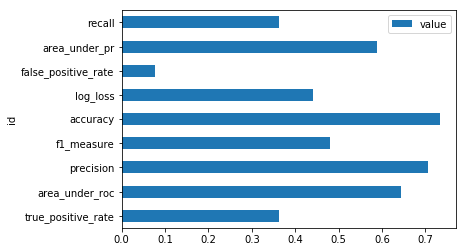

In [51]:
%matplotlib inline

quality_pd = subscription.quality_monitoring.get_table_content(format='pandas')
quality_pd.plot.barh(x='id', y='value');

In [52]:
ai_client.data_mart.get_deployment_metrics()

{'deployment_metrics': [{'asset': {'asset_id': '079fcb25-37ab-4d1f-89cb-430c58251896',
    'asset_type': 'model',
    'created_at': '2019-10-31T15:20:01.002Z',
    'name': 'ktestHeart XGBoost softprob model',
    'url': 'https://ibm-nginx-svc.namespace1.svc.cluster.local/v4/models/079fcb25-37ab-4d1f-89cb-430c58251896?space_id=323608a7-21d3-48c8-8c62-dcf4bfe06e17'},
   'deployment': {'created_at': '2019-10-31T15:20:20.503Z',
    'deployment_id': '46d1a7a5-35aa-40af-bcac-467f686df406',
    'deployment_type': 'online',
    'description': 'xgbheart082_deployment_v4model_v4depl',
    'name': 'test XGB Heart 082',
    'scoring_endpoint': {'request_headers': {'Content-Type': 'application/json'},
     'url': 'https://ibm-nginx-svc.namespace1.svc.cluster.local/v4/deployments/46d1a7a5-35aa-40af-bcac-467f686df406/predictions'},
    'url': 'https://ibm-nginx-svc.namespace1.svc.cluster.local/v4/deployments/46d1a7a5-35aa-40af-bcac-467f686df406'},
   'metrics': [],
   'subscription': {'subscription_i

# Fairness, drift monitoring and explanations 
 <a name="fairness"></a>

The code below configures fairness monitoring for our model. It turns on monitoring for two features, Sex and Age. In each case, we must specify:
  * Which model feature to monitor
  * One or more **majority** groups, which are values of that feature that we expect to receive a higher percentage of favorable outcomes
  * One or more **minority** groups, which are values of that feature that we expect to receive a higher percentage of unfavorable outcomes
  * The threshold at which we would like OpenScale to display an alert if the fairness measurement falls below (in this case, 95%)

Additionally, we must specify which outcomes from the model are favourable outcomes, and which are unfavourable. We must also provide the number of records OpenScale will use to calculate the fairness score. In this case, OpenScale's fairness monitor will run hourly, but will not calculate a new fairness rating until at least 200 records have been added. Finally, to calculate fairness, OpenScale must perform some calculations on the training data, so we provide the dataframe containing the data.

In [53]:
subscription.fairness_monitoring.enable(
            features=[
                Feature("Sex", majority=['male'], minority=['female'], threshold=0.95),
                Feature("Age", majority=[[26,75]], minority=[[18,25]], threshold=0.95)
            ],
            favourable_classes=['No Risk'],
            unfavourable_classes=['Risk'],
            min_records=200,
            training_data=pd_data
        )

## Drift configuration

In [1]:
subscription.drift_monitoring.enable(min_records=100, threshold=0.1)

drift_status = None
while drift_status != 'finished':
    drift_details = subscription.drift_monitoring.get_details()
    drift_status = drift_details['parameters']['config_status']['state']
    if drift_status != 'finished':
        print(datetime.utcnow().strftime('%H:%M:%S'), drift_status)
        time.sleep(30)
print(drift_status)



NameError: name 'subscription' is not defined

## Score the model again now that monitoring is configured

This next section randomly selects 200 records from the data feed and sends those records to the model for predictions. This is enough to exceed the minimum threshold for records set in the previous section, which allows OpenScale to begin calculating fairness.

In [54]:
!rm german_credit_feed.json
!wget https://raw.githubusercontent.com/pmservice/ai-openscale-tutorials/master/assets/historical_data/german_credit_risk/wml/german_credit_feed.json

rm: cannot remove 'german_credit_feed.json': No such file or directory
--2019-11-01 19:12:11--  https://raw.githubusercontent.com/pmservice/ai-openscale-tutorials/master/assets/historical_data/german_credit_risk/wml/german_credit_feed.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.188.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.188.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3076279 (2.9M) [text/plain]
Saving to: 'german_credit_feed.json'

100%[======================================>] 3,076,279   2.51MB/s   in 1.2s   

2019-11-01 19:12:12 (2.51 MB/s) - 'german_credit_feed.json' saved [3076279/3076279]



Score 200 randomly chosen records

In [55]:
import random

with open('german_credit_feed.json', 'r') as scoring_file:
    scoring_data = json.load(scoring_file)

fields = scoring_data['fields']
values = []
for _ in range(200):
    values.append(random.choice(scoring_data['values']))
payload_scoring = {"fields": fields, "values": values}
payload = {
    wml_client.deployments.ScoringMetaNames.INPUT_DATA: [payload_scoring]
}
scoring_response = wml_client.deployments.score(deployment_uid, payload)

## Run fairness monitor

Kick off a fairness monitor run on current data. The monitor runs hourly, but can be manually initiated using the Python client, the REST API, or the graphical user interface.

In [56]:
time.sleep(5)

run_details = subscription.fairness_monitoring.run(background_mode=False)




 Counting bias for deployment_uid=c592c5af-8aab-463f-96df-d1904896e1ff 




RUNNING............
FINISHED

---------------------------
 Successfully finished run 
---------------------------




In [57]:
time.sleep(5)

subscription.fairness_monitoring.show_table()

2019-11-01 19:12:32.321664+00:00,Sex,female,True,0.936,66.0,999,39ffe632-77dd-4c6c-aee3-74755bc8b551,39ffe632-77dd-4c6c-aee3-74755bc8b551,c592c5af-8aab-463f-96df-d1904896e1ff,
2019-11-01 19:12:32.321664+00:00,Age,"[18, 25]",False,1.094,76.0,999,39ffe632-77dd-4c6c-aee3-74755bc8b551,39ffe632-77dd-4c6c-aee3-74755bc8b551,c592c5af-8aab-463f-96df-d1904896e1ff,


## Run drift monitor

Kick off a drift monitor run on current data. The monitor runs every hour, but can be manually initiated using the Python client, the REST API.

In [ ]:
drift_run_details = subscription.drift_monitoring.run(background_mode=False)

In [ ]:
subscription.drift_monitoring.get_table_content()

## Configure Explainability

Finally, we provide OpenScale with the training data to enable and configure the explainability features.

In [58]:
from ibm_ai_openscale.supporting_classes import *
subscription.explainability.enable(training_data=pd_data)

In [59]:
explainability_details = subscription.explainability.get_details()

## Run explanation for sample record

In [60]:
transaction_id = subscription.payload_logging.get_table_content(limit=1)['scoring_id'].values[0]

print(transaction_id)

87292981-bdd6-4abe-8891-fc4c434f35b9-1


In [61]:
explain_run = subscription.explainability.run(transaction_id=transaction_id, background_mode=False)




 Looking for explanation for 87292981-bdd6-4abe-8891-fc4c434f35b9-1 




in_progress...........................

---------------
 Run timed out 
---------------


The run didn't finish within 180s.


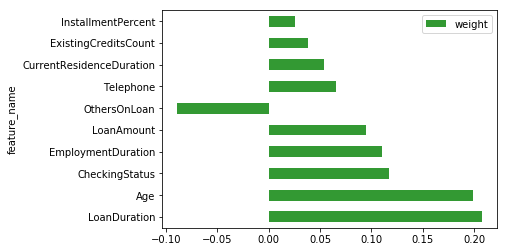

In [80]:
if explain_run == None:
    # explanation didn't finish within 180 seconds, if explaination is still not finished give it a minute or so then re-run this cell
    time.sleep(10)
    explain_table = subscription.explainability.get_table_content(format='pandas')
    explain_result = pd.DataFrame.from_dict(explain_table[explain_table['transaction_id']==transaction_id]['explanation'][0]['entity']['predictions'][0]['explanation_features'])
else:
    explain_result = pd.DataFrame.from_dict(explain_run['entity']['predictions'][0]['explanation_features'])

explain_result.plot.barh(x='feature_name', y='weight', color='g', alpha=0.8);

# Custom monitors and metrics <a name="custom"></a>

## Register custom monitor

In [81]:
def get_definition(monitor_name):
    monitors_definitions = ai_client.data_mart.monitors.get_details()['monitor_definitions']
    
    for definition in monitors_definitions:
        if monitor_name == definition['entity']['name']:
            return definition
    
    return None

In [82]:
from ibm_ai_openscale.supporting_classes import Metric, Tag

monitor_name = 'my model performance'
metrics = [Metric(name='sensitivity', lower_limit_default=0.8), Metric(name='specificity', lower_limit_default=0.75)]
tags = [Tag(name='region', description='customer geographical region')]

existing_definition = get_definition(monitor_name)

if existing_definition is None:
    my_monitor = ai_client.data_mart.monitors.add(name=monitor_name, metrics=metrics, tags=tags)
else:
    my_monitor = existing_definition

### List monitors

### Get monitors uids and details

In [83]:
monitor_uid = my_monitor['metadata']['guid']

print(monitor_uid)

my_model_performance


In [84]:
my_monitor = ai_client.data_mart.monitors.get_details(monitor_uid=monitor_uid)
print('monitor definition details', my_monitor)

monitor definition details {'entity': {'metrics': [{'expected_direction': 'increasing', 'id': 'sensitivity', 'name': 'sensitivity', 'required': True, 'thresholds': [{'default': 0.8, 'type': 'lower_limit'}]}, {'expected_direction': 'increasing', 'id': 'specificity', 'name': 'specificity', 'required': True, 'thresholds': [{'default': 0.75, 'type': 'lower_limit'}]}], 'name': 'my model performance', 'tags': [{'description': 'customer geographical region', 'id': 'region', 'name': 'region', 'required': True}]}, 'metadata': {'guid': 'my_model_performance', 'url': '/v1/data_marts/00000000-0000-0000-0000-000000000000/monitor_definitions/my_model_performance', 'created_at': '2019-11-01T19:31:57.105Z'}}


## Enable custom monitor for subscription

In [85]:
from ibm_ai_openscale.supporting_classes import Threshold

thresholds = [Threshold(metric_uid='sensitivity', lower_limit=0.9)]
subscription.monitoring.enable(monitor_uid=monitor_uid, thresholds=thresholds)

### Get monitor configuration details

In [86]:
subscription.monitoring.get_details(monitor_uid=monitor_uid)

{'enabled': True,
 'monitor_definition': {'entity': {'metrics': [{'expected_direction': 'increasing',
     'id': 'sensitivity',
     'name': 'sensitivity',
     'required': True,
     'thresholds': [{'default': 0.9, 'type': 'lower_limit'}]},
    {'expected_direction': 'increasing',
     'id': 'specificity',
     'name': 'specificity',
     'required': True}],
   'name': 'my model performance',
   'tags': [{'description': 'customer geographical region',
     'id': 'region',
     'name': 'region',
     'required': True}]},
  'metadata': {'guid': 'my_model_performance',
   'url': '/v1/data_marts/00000000-0000-0000-0000-000000000000/monitor_definitions/my_model_performance',
   'created_at': '2019-11-01T19:31:57.105Z'}},
 'thresholds': [{'metric_id': 'sensitivity',
   'type': 'lower_limit',
   'value': 0.9}]}

## Storing custom metrics

In [87]:
metrics = {"specificity": 0.78, "sensitivity": 0.67, "region": "us-south"}

subscription.monitoring.store_metrics(monitor_uid=monitor_uid, metrics=metrics)

[{'asset_id': '4728915f-08bc-493d-8453-3aaf4d981d75',
  'binding_id': '999',
  'measurement_id': 'ee13d597-d19b-483e-8ff0-53744664be89',
  'metrics': [{'region': 'us-south',
    'sensitivity': 0.67,
    'specificity': 0.78}],
  'monitor_definition_id': 'my_model_performance',
  'subscription_id': '39ffe632-77dd-4c6c-aee3-74755bc8b551',
  'timestamp': '2019-11-01T19:32:10.721845Z'}]

### List and get custom metrics

In [88]:
subscription.monitoring.show_table(monitor_uid=monitor_uid)

2019-11-01 19:32:10.721845+00:00,sensitivity,ee13d597-d19b-483e-8ff0-53744664be89,0.67,0.9,,region: us-south,999,39ffe632-77dd-4c6c-aee3-74755bc8b551,c592c5af-8aab-463f-96df-d1904896e1ff
2019-11-01 19:32:10.721845+00:00,specificity,ee13d597-d19b-483e-8ff0-53744664be89,0.78,,,region: us-south,999,39ffe632-77dd-4c6c-aee3-74755bc8b551,c592c5af-8aab-463f-96df-d1904896e1ff


In [89]:
custom_metrics = subscription.monitoring.get_metrics(monitor_uid=monitor_uid, deployment_uid='credit')
custom_metrics

[{'asset_id': '4728915f-08bc-493d-8453-3aaf4d981d75',
  'binding_id': '999',
  'tags': [{'id': 'region', 'value': 'us-south'}],
  'ts': '2019-11-01T19:32:10.721845Z',
  'measurement_id': 'ee13d597-d19b-483e-8ff0-53744664be89',
  'monitor_definition_id': 'my_model_performance',
  'subscription_id': '39ffe632-77dd-4c6c-aee3-74755bc8b551',
  'metrics': [{'lower_limit': 0.9, 'id': 'sensitivity', 'value': 0.67},
   {'id': 'specificity', 'value': 0.78}]}]

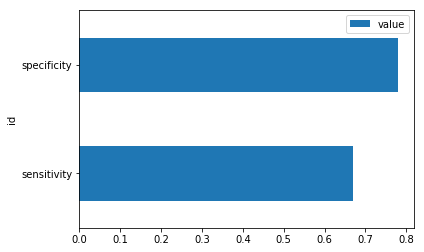

In [90]:
custom_metrics_pandas = subscription.monitoring.get_table_content(monitor_uid=monitor_uid)

%matplotlib inline
custom_metrics_pandas.plot.barh(x='id', y='value');

# Payload analytics <a name="analytics"></a>

## Run data distributions calculation

In [91]:
from datetime import datetime

start_date = "2018-01-01T00:00:00.00Z"
end_date = datetime.utcnow().isoformat() + "Z"

sex_distribution = subscription.payload_logging.data_distribution.run(
            start_date=start_date,
            end_date=end_date,
            group=['predictedLabel', 'Sex'],
            agg=['count'])




 Waiting for end of data distribution run 42487c08-8e15-4df8-9a96-2e0ffba2ced5 




running
completed

---------------------------
 Successfully finished run 
---------------------------




## Get data distributions as pandas dataframe

In [92]:
sex_distribution_run_uid = sex_distribution['id']
distributions_pd = subscription.payload_logging.data_distribution.get_run_result(run_id=sex_distribution_run_uid, format='pandas')
distributions_pd

,predictedLabel,Sex,count
0,No Risk,female,89
1,No Risk,male,138
2,Risk,female,6
3,Risk,male,73


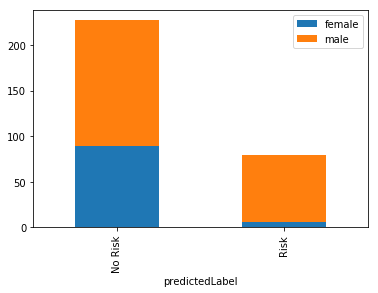

In [93]:
subscription.payload_logging.data_distribution.show_chart(sex_distribution_run_uid);

In [94]:
credit_history_distribution = subscription.payload_logging.data_distribution.run(
            start_date=start_date,
            end_date=end_date,
            group=['predictedLabel', 'CreditHistory'],
            agg=['count'])




 Waiting for end of data distribution run 3f3ddb67-b3bb-4f5b-a7fb-1c93999f7311 




running.
completed

---------------------------
 Successfully finished run 
---------------------------




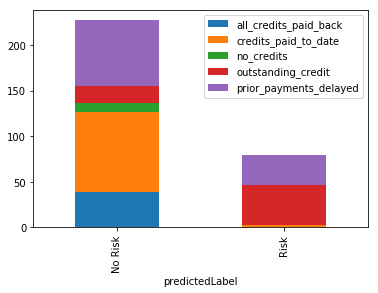

In [95]:
credit_history_distribution_run_uid = credit_history_distribution['id']

subscription.payload_logging.data_distribution.show_chart(credit_history_distribution_run_uid);

# Historical data <a name="historical"></a>

 ## Insert historical payloads

The next section of the notebook downloads and writes historical data to the payload and measurement tables to simulate a production model that has been monitored and receiving regular traffic for the last seven days. This historical data can be viewed in the Watson OpenScale user interface. The code uses the Python and REST APIs to write this data.

In [96]:
!rm history_payloads*.json
!wget https://raw.githubusercontent.com/pmservice/ai-openscale-tutorials/master/assets/historical_data/german_credit_risk/wml/history_payloads_0.json
!wget https://raw.githubusercontent.com/pmservice/ai-openscale-tutorials/master/assets/historical_data/german_credit_risk/wml/history_payloads_1.json
!wget https://raw.githubusercontent.com/pmservice/ai-openscale-tutorials/master/assets/historical_data/german_credit_risk/wml/history_payloads_2.json
!wget https://raw.githubusercontent.com/pmservice/ai-openscale-tutorials/master/assets/historical_data/german_credit_risk/wml/history_payloads_3.json
!wget https://raw.githubusercontent.com/pmservice/ai-openscale-tutorials/master/assets/historical_data/german_credit_risk/wml/history_payloads_4.json
!wget https://raw.githubusercontent.com/pmservice/ai-openscale-tutorials/master/assets/historical_data/german_credit_risk/wml/history_payloads_5.json
!wget https://raw.githubusercontent.com/pmservice/ai-openscale-tutorials/master/assets/historical_data/german_credit_risk/wml/history_payloads_6.json

rm: cannot remove 'history_payloads*.json': No such file or directory
--2019-11-01 19:33:36--  https://raw.githubusercontent.com/pmservice/ai-openscale-tutorials/master/assets/historical_data/german_credit_risk/wml/history_payloads_0.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.128.133, 151.101.192.133, 151.101.64.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.128.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5018899 (4.8M) [text/plain]
Saving to: 'history_payloads_0.json'

100%[======================================>] 5,018,899   2.52MB/s   in 1.9s   

2019-11-01 19:33:39 (2.52 MB/s) - 'history_payloads_0.json' saved [5018899/5018899]

--2019-11-01 19:33:40--  https://raw.githubusercontent.com/pmservice/ai-openscale-tutorials/master/assets/historical_data/german_credit_risk/wml/history_payloads_1.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.128.13

In [97]:
historyDays = 7

In [99]:
from ibm_ai_openscale.supporting_classes import PayloadRecord, Feature
import datetime
import time

for day in range(historyDays):
    print('Loading day {}'.format(day + 1))
    history_file = 'history_payloads_' + str(day) + '.json'
    with open(history_file) as f:
        payloads = json.load(f)
        hourly_records = int(len(payloads) / 24)
        index = 0
        for hour in range(24):
            recordsList = []
            for i in range(hourly_records):
                score_time = str(datetime.datetime.utcnow() + datetime.timedelta(hours=(-(24*day + hour + 1))))
                recordsList.append(PayloadRecord(request=payloads[index]['request'], response=payloads[index]['response'], scoring_timestamp=score_time))
                index += 1
            subscription.payload_logging.store(records=recordsList)
print('Finished')

Loading day 1
Loading day 2
Loading day 3
Loading day 4
Loading day 5
Loading day 6
Loading day 7
Finished


In [100]:
data_mart_id = subscription.get_details()['metadata']['url'].split('/service_bindings')[0].split('marts/')[1]
print(data_mart_id)

00000000-0000-0000-0000-000000000000


In [101]:
performance_metrics_url = WOS_CREDENTIALS['url'] + subscription.get_details()['metadata']['url'].split('/service_bindings')[0] + '/metrics'
print(performance_metrics_url)

https://namespace1-cpd-namespace1.apps.aiosrc3-lb-1.fyre.ibm.com/v1/data_marts/00000000-0000-0000-0000-000000000000/metrics


## Insert historical fairness metrics

In [102]:
!rm history_fairness.json
!wget https://raw.githubusercontent.com/pmservice/ai-openscale-tutorials/master/assets/historical_data/german_credit_risk/wml/history_fairness.json

rm: cannot remove 'history_fairness.json': No such file or directory
--2019-11-01 20:00:33--  https://raw.githubusercontent.com/pmservice/ai-openscale-tutorials/master/assets/historical_data/german_credit_risk/wml/history_fairness.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.188.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.188.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1424078 (1.4M) [text/plain]
Saving to: 'history_fairness.json'

100%[======================================>] 1,424,078   1.38MB/s   in 1.0s   

2019-11-01 20:00:34 (1.38 MB/s) - 'history_fairness.json' saved [1424078/1424078]



In [103]:
from requests.auth import HTTPBasicAuth

def create_token():
    header = {
                    "Content-Type": "application/x-www-form-urlencoded",
                    "Accept": "application/json"
    }

    response = requests_session.get(
            WOS_CREDENTIALS['url'] + '/v1/preauth/validateAuth',
            headers=header,
            auth=HTTPBasicAuth(
                WOS_CREDENTIALS['username'],
                WOS_CREDENTIALS['password']
            ),
            verify=False)

    response = handle_response(200, 'access token', response, True)
    token = response['accessToken']

    return token

In [104]:
iam_token = create_token()
iam_headers = {
    'Content-Type': 'application/json',
    'Authorization': 'Bearer %s' % iam_token
}

with open('history_fairness.json', 'r') as history_file:
    payloads = json.load(history_file)

for day in range(historyDays):
    print('Loading day', day + 1)
    for hour in range(24):
        score_time = (datetime.datetime.utcnow() + datetime.timedelta(hours=(-(24*day + hour + 1)))).strftime('%Y-%m-%dT%H:%M:%SZ')
        index = (day * 24 + hour) % len(payloads) # wrap around and reuse values if needed
        
        qualityMetric = {
            'metric_type': 'fairness',
            'binding_id': binding_uid,
            'timestamp': score_time,
            'subscription_id': model_uid,
            'asset_revision': model_uid,
            'deployment_id': deployment_uid,
            'value': payloads[index]
        }

        response = requests.post(performance_metrics_url, json=[qualityMetric], headers=iam_headers, verify=False)

print('Finished')

Loading day 1
Loading day 2
Loading day 3
Loading day 4
Loading day 5
Loading day 6
Loading day 7
Finished


## Insert historical debias metrics

In [105]:
!rm history_debias.json
!wget https://raw.githubusercontent.com/pmservice/ai-openscale-tutorials/master/assets/historical_data/german_credit_risk/wml/history_debias.json

rm: cannot remove 'history_debias.json': No such file or directory
--2019-11-01 20:07:22--  https://raw.githubusercontent.com/pmservice/ai-openscale-tutorials/master/assets/historical_data/german_credit_risk/wml/history_debias.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.64.133, 151.101.128.133, 151.101.192.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.64.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 565971 (553K) [text/plain]
Saving to: 'history_debias.json'

100%[======================================>] 565,971      800KB/s   in 0.7s   

2019-11-01 20:07:23 (800 KB/s) - 'history_debias.json' saved [565971/565971]



In [106]:
iam_token = create_token()
iam_headers = {
    'Content-Type': 'application/json',
    'Authorization': 'Bearer %s' % iam_token
}

with open('history_debias.json', 'r') as history_file:
    payloads = json.load(history_file)

for day in range(historyDays):
    print('Loading day', day + 1)
    for hour in range(24):
        score_time = (datetime.datetime.utcnow() + datetime.timedelta(hours=(-(24*day + hour + 1)))).strftime('%Y-%m-%dT%H:%M:%SZ')
        index = (day * 24 + hour) % len(payloads) # wrap around and reuse values if needed

        qualityMetric = {
            'metric_type': 'debiased_fairness',
            'binding_id': binding_uid,
            'timestamp': score_time,
            'subscription_id': model_uid,
            'asset_revision': model_uid,
            'deployment_id': deployment_uid,
            'value': payloads[index]
        }

        response = requests.post(performance_metrics_url, json=[qualityMetric], headers=iam_headers, verify=False)
print('Finished')

Loading day 1
Loading day 2
Loading day 3
Loading day 4
Loading day 5
Loading day 6
Loading day 7
Finished


## Insert historical quality metrics

In [107]:
iam_token = create_token()
iam_headers = {
    'Content-Type': 'application/json',
    'Authorization': 'Bearer %s' % iam_token
}

measurements = [0.76, 0.78, 0.68, 0.72, 0.73, 0.77, 0.80]
for day in range(historyDays):
    print('Day', day + 1)
    for hour in range(24):
        score_time = (datetime.datetime.utcnow() + datetime.timedelta(hours=(-(24*day + hour + 1)))).strftime('%Y-%m-%dT%H:%M:%SZ')
        qualityMetric = {
            'metric_type': 'quality',
            'binding_id': binding_uid,
            'timestamp': score_time,
            'subscription_id': model_uid,
            'asset_revision': model_uid,
            'deployment_id': deployment_uid,
            'value': {
                'quality': measurements[day],
                'threshold': 0.7,
                'metrics': [
                    {
                        'name': 'auroc',
                        'value': measurements[day],
                        'threshold': 0.7
                    }
                ]
            }
        }

        response = requests.post(performance_metrics_url, json=[qualityMetric], headers=iam_headers, verify=False)
print('Finished')

Day 1
Day 2
Day 3
Day 4
Day 5
Day 6
Day 7
Finished


## Insert historical confusion matrixes

In [108]:
!rm history_quality_metrics.json
# !wget https://raw.githubusercontent.com/pmservice/ai-openscale-tutorials/master/assets/historical_data/german_credit_risk/wml/history_quality_metrics.json
!wget https://raw.githubusercontent.com/pmservice/ai-openscale-tutorials/master/assets/historical_data/german_credit_risk/wos/history_quality_metrics.json

rm: cannot remove 'history_quality_metrics.json': No such file or directory
--2019-11-01 20:09:14--  https://raw.githubusercontent.com/pmservice/ai-openscale-tutorials/master/assets/historical_data/german_credit_risk/wos/history_quality_metrics.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.40.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.40.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 80099 (78K) [text/plain]
Saving to: 'history_quality_metrics.json'

100%[======================================>] 80,099      89.9KB/s   in 0.9s   

2019-11-01 20:09:16 (89.9 KB/s) - 'history_quality_metrics.json' saved [80099/80099]



In [109]:
measurements_url = WOS_CREDENTIALS['url'] + subscription.get_details()['metadata']['url'].split('/service_bindings')[0] + '/measurements'
print(measurements_url)

https://namespace1-cpd-namespace1.apps.aiosrc3-lb-1.fyre.ibm.com/v1/data_marts/00000000-0000-0000-0000-000000000000/measurements


In [110]:
with open('history_quality_metrics.json') as json_file:
    records = json.load(json_file)

for day in range(historyDays):
    index = 0
    measurments = []
    print('Day', day + 1)
    
    for hour in range(24):
        score_time = (datetime.datetime.utcnow() + datetime.timedelta(hours=(-(24*day + hour + 1)))).strftime('%Y-%m-%dT%H:%M:%SZ')

        measurement = {
            "monitor_definition_id": 'quality',
            "binding_id": subscription.binding_uid,
            "subscription_id": subscription.uid,
            "asset_id": subscription.source_uid,
            'metrics': [records[index]['metrics']],
            'sources': [records[index]['sources']],
            'timestamp': score_time
        }

        measurments.append(measurement)
        index+=1

    response = requests.post(measurements_url, json=measurments, headers=ai_client._get_headers(), verify=False)

print('Finished')

Day 1
Day 2
Day 3
Day 4
Day 5
Day 6
Day 7
Finished


## Insert historical performance metrics

In [111]:
iam_token = create_token()
iam_headers = {
    'Content-Type': 'application/json',
    'Authorization': 'Bearer %s' % iam_token
}

for day in range(historyDays):
    print('Day', day + 1)
    for hour in range(24):
        score_time = (datetime.datetime.utcnow() + datetime.timedelta(hours=(-(24*day + hour + 1)))).strftime('%Y-%m-%dT%H:%M:%SZ')
        score_count = random.randint(60, 600)
        score_resp = random.uniform(60, 300)

        performanceMetric = {
            'metric_type': 'performance',
            'binding_id': binding_uid,
            'timestamp': score_time,
            'subscription_id': model_uid,
            'asset_revision': model_uid,
            'deployment_id': deployment_uid,
            'value': {
                'response_time': score_resp,
                'records': score_count
            }
        }

        response = requests.post(performance_metrics_url, json=[performanceMetric], headers=iam_headers, verify=False)
print('Finished')

Day 1
Day 2
Day 3
Day 4
Day 5
Day 6
Day 7
Finished


## Insert historical manual labeling

In [112]:
manual_labeling_url = WOS_CREDENTIALS['url'] + subscription.get_details()['metadata']['url'].split('/service_bindings')[0] + '/manual_labelings'
print(manual_labeling_url)

https://namespace1-cpd-namespace1.apps.aiosrc3-lb-1.fyre.ibm.com/v1/data_marts/00000000-0000-0000-0000-000000000000/manual_labelings


In [113]:
!rm history_manual_labeling.json
!wget https://raw.githubusercontent.com/pmservice/ai-openscale-tutorials/master/assets/historical_data/german_credit_risk/wml/history_manual_labeling.json

rm: cannot remove 'history_manual_labeling.json': No such file or directory
--2019-11-01 20:10:29--  https://raw.githubusercontent.com/pmservice/ai-openscale-tutorials/master/assets/historical_data/german_credit_risk/wml/history_manual_labeling.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.188.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.188.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 947956 (926K) [text/plain]
Saving to: 'history_manual_labeling.json'

100%[======================================>] 947,956     1.01MB/s   in 0.9s   

2019-11-01 20:10:31 (1.01 MB/s) - 'history_manual_labeling.json' saved [947956/947956]



In [114]:
iam_token = create_token()
iam_headers = {
    'Content-Type': 'application/json',
    'Authorization': 'Bearer %s' % iam_token
}

with open('history_manual_labeling.json', 'r') as history_file:
    records = json.load(history_file)

for day in range(historyDays):
    print('Loading day', day + 1)
    record_json = []
    for hour in range(24):
        for record in records:
            if record['fastpath_history_day'] == day and record['fastpath_history_hour'] == hour:
                record['binding_id'] = binding_uid
                record['subscription_id'] = model_uid
                record['asset_revision'] = model_uid
                record['deployment_id'] = deployment_uid
                record['scoring_timestamp'] = (datetime.datetime.utcnow() + datetime.timedelta(hours=(-(24*day + hour + 1)))).strftime('%Y-%m-%dT%H:%M:%SZ')
                record_json.append(record)
    response = requests.post(manual_labeling_url, json=record_json, headers=iam_headers, verify=False)

print('Finished')

Loading day 1
Loading day 2
Loading day 3
Loading day 4
Loading day 5
Loading day 6
Loading day 7
Finished


## Additional data to help debugging

In [115]:
print('Datamart:', data_mart_id)
print('Model:', model_uid)
print('Deployment:', deployment_uid)
print('Binding:', binding_uid)
print('Scoring URL:', credit_risk_scoring_endpoint)

Datamart: 00000000-0000-0000-0000-000000000000
Model: 4728915f-08bc-493d-8453-3aaf4d981d75
Deployment: c592c5af-8aab-463f-96df-d1904896e1ff
Binding: 999
Scoring URL: https://namespace1-cpd-namespace1.apps.aiosrc3-lb-1.fyre.ibm.com/v4/deployments/c592c5af-8aab-463f-96df-d1904896e1ff/predictions


## Identify transactions for Explainability

Transaction IDs identified by the cells below can be copied and pasted into the Explainability tab of the OpenScale dashboard.

In [116]:
payload_data = subscription.payload_logging.get_table_content(limit=60)
payload_data.filter(items=['scoring_id', 'predictedLabel', 'probability'])

,scoring_id,predictedLabel,probability
0,87292981-bdd6-4abe-8891-fc4c434f35b9-1,Risk,"[0.28568451903796876, 0.7143154809620312]"
1,87292981-bdd6-4abe-8891-fc4c434f35b9-2,No Risk,"[0.5924680453531743, 0.4075319546468257]"
2,87292981-bdd6-4abe-8891-fc4c434f35b9-3,No Risk,"[0.7415614091936191, 0.25843859080638093]"
3,87292981-bdd6-4abe-8891-fc4c434f35b9-4,No Risk,"[0.7523865698676778, 0.24761343013232215]"
4,87292981-bdd6-4abe-8891-fc4c434f35b9-5,No Risk,"[0.5285525551420646, 0.47144744485793544]"
5,87292981-bdd6-4abe-8891-fc4c434f35b9-6,No Risk,"[0.5705810561309088, 0.4294189438690913]"
6,87292981-bdd6-4abe-8891-fc4c434f35b9-7,Risk,"[0.1924704448191712, 0.8075295551808288]"
7,87292981-bdd6-4abe-8891-fc4c434f35b9-8,No Risk,"[0.5547387931383087, 0.44526120686169135]"
8,87292981-bdd6-4abe-8891-fc4c434f35b9-9,No Risk,"[0.9829643104083582, 0.017035689591641912]"
9,87292981-bdd6-4abe-8891-fc4c434f35b9-10,Risk,"[0.48911852026651514, 0.5108814797334847]"


## Congratulations!

You have finished the hands-on lab for IBM Watson OpenScale. You can now view the [OpenScale Dashboard](https://aiopenscale.cloud.ibm.com/). Click on the tile for the German Credit model to see fairness, accuracy, and performance monitors. Click on the timeseries graph to get detailed information on transactions during a specific time window.


## Authors

Eric Martens, is a technical specialist having expertise in analysis and description of business processes, and their translation into functional and non-functional IT requirements. He acts as the interpreter between the worlds of IT and business.

Lukasz Cmielowski, PhD, is an Automation Architect and Data Scientist at IBM with a track record of developing enterprise-level applications that substantially increases clients' ability to turn data into actionable knowledge.

Zilu (Peter) Tang, is a cognitive developer with experties in deep learning and enterprise AI solutions from Watson Openscale to many other cutting-edge IBM research projects.